## PCA Analysis

The steps to do dimentionality reduction are:

1. Important: Scale the data around zero, use StandardScalar


We choose MIST dataset as it has 28x28 = 764-dimensions.

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_absolute_error, mean_squared_error

mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [2]:
X_orig, y = mnist['data'], mnist['target']

# feature_names, categories.class:[0--9]
feature_names = mnist["feature_names"]
classes = mnist["categories"]["class"]
print(f"features: {len(feature_names)}, clases: {len(classes)}")
print(f"X.shape: {X_orig.shape}, y: {y.shape}")

features: 784, clases: 10
X.shape: (70000, 784), y: (70000,)


In [3]:
from sklearn.preprocessing import StandardScaler
import numpy as np
# Step1: Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X_orig)

# Step 2: Get co-variance metric, np.cov() assumes each row is a feature
X_cov = np.cov(X.T)

# Step 3: Get eigen values and eigen vectors
eigen_values, eigen_vectors = np.linalg.eig(X_cov)

print(f"X: {X.shape}, X.T: {X.T.shape}, X_cov {X_cov.shape}")
print(f"eigen_values {eigen_values.shape}, eigen_vectors {eigen_vectors.shape}")


X: (70000, 784), X.T: (784, 70000), X_cov (784, 784)
eigen_values (784,), eigen_vectors (784, 784)


In [4]:
# Step 4: Sort eigen values and eigen vectors
idx = np.argsort(eigen_values)[::-1]
sorted_eigen_values = eigen_values[idx]
sorted_eigen_vectors = eigen_vectors[:, idx]

# Print list to 2 decimal places
print("Top 10 eigen values:", end="")
for i in range(10):
    print(f"{sorted_eigen_values[i]:6.2f}, ", end="")
print("\nPer 10 eigen values:", end="")
eigen_values_sum = sum(sorted_eigen_values)
for i in range(10):
    print(f"{100*sorted_eigen_values[i]/eigen_values_sum:5.2f}%, ", end="")
print("\nLow 10 eigen values:", end="")
for i in range(10):
    print(f"{sorted_eigen_values[len(sorted_eigen_values)-1-i]:6.2f}, ", end="")

# count number of eigne values closer to zero
zero_eigen_values = sum(1 for x in sorted_eigen_values if x < 1e-10)
print()
print(f"Number of eigen values closer to zero: {zero_eigen_values}")

Top 10 eigen values: 40.57,  29.06,  26.88,  20.80,  18.12,  15.76,  13.76,  12.52,  11.02,  10.04, 
Per 10 eigen values: 5.64%,  4.04%,  3.74%,  2.89%,  2.52%,  2.19%,  1.91%,  1.74%,  1.53%,  1.40%, 
Low 10 eigen values: -0.00,  -0.00,  -0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00, 
Number of eigen values closer to zero: 71


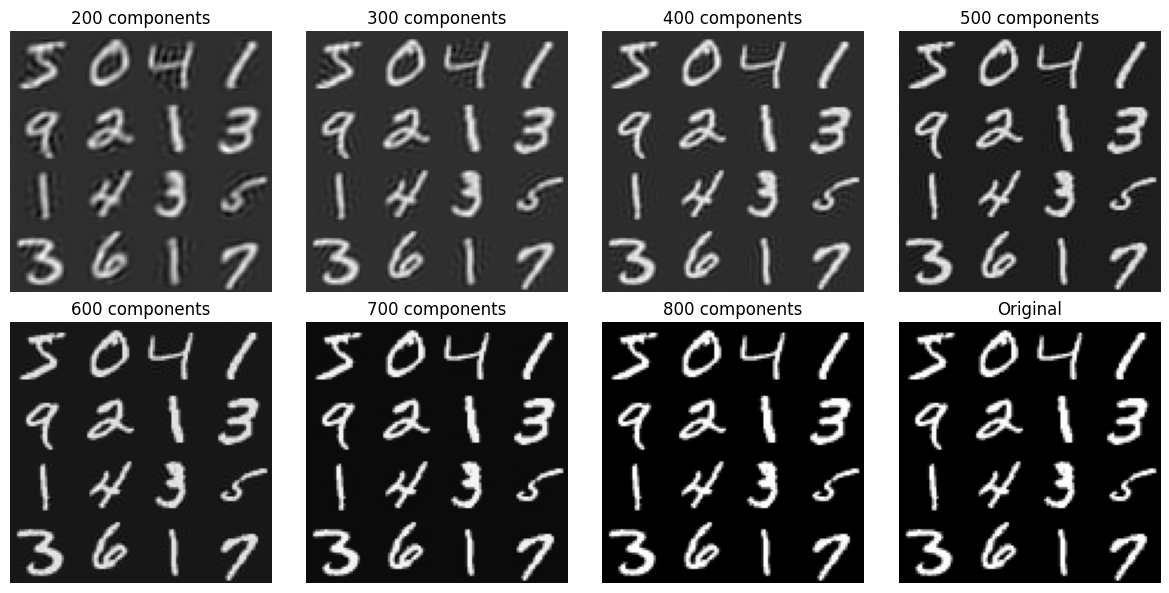

In [5]:
import matplotlib.pyplot as plt

errors = []
components = list(range(200, 900, 100))  # includes 784
fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # 2 rows x 4 columns
for idx, n_comp in enumerate(components):
    # Step 5: Select top K eigen values and eigen vectors
    projection_matrix = sorted_eigen_vectors[:, :n_comp]
    # Step 6: Project the data onto the new feature space
    X_pca = X @ projection_matrix
    X_pca_reconstructed = X_pca @ projection_matrix.T
    X_pca_reconstructed_unscaled = scaler.inverse_transform(X_pca_reconstructed)
    mae = mean_absolute_error(X_orig, X_pca_reconstructed_unscaled)
    mse= mean_squared_error(X_orig, X_pca_reconstructed_unscaled)
    errors.append([n_comp if n_comp < len(sorted_eigen_vectors)
                  else len(sorted_eigen_vectors), mae, mse])

    # Prepare the subplot
    ax = axes[idx // 4, idx % 4]
    # takes the first 16 images (each 28×28) and arranges them into a
    # single 112×112 image (4×4 grid) for visualization.
    tile = X_pca_reconstructed_unscaled[:16].reshape(
        4, 4, 28, 28).swapaxes(1, 2).reshape(4*28, 4*28)
    ax.imshow(tile, cmap='gray')
    ax.set_title(f'{n_comp} components')
    ax.axis('off')

# Show original images on last column of last row
tile = X_orig[:16].reshape(
        4, 4, 28, 28).swapaxes(1, 2).reshape(4*28, 4*28)
axes[1,3].imshow(tile, cmap='gray')
axes[1, 3].set_title('Original')
axes[1, 3].axis('off')
plt.tight_layout()
plt.show()

# Mean Absolute Error
 - Directly interpretable in terms of pixel intensity differences (range: 0–255).
 - A MAE of 10 means, on average, each pixel is off by 10 gray levels, which is perceptually understandable.
 - Less sensitive to outliers than MSE.

| Components | MAE | Comment |
|--|--|--|
| 200 | 11.9 | Noticeable distortion |
| 400 | 6.7 | Acceptable for digit recognition |
| 600 | 3 | High fidelity |
| 700 | 0.7 | Nearly lossless |
| 800 | ~0 | Perfect reconstruction (no information loss) |

In [6]:
from tabulate import tabulate
print(tabulate(errors, headers=["Components", "MAE", "MSE"]))

  Components           MAE           MSE
------------  ------------  ------------
         200  11.8722       511.838
         300   8.79698      286.561
         400   6.74752      172.647
         500   4.81681       91.5996
         600   3.04347       37.5123
         700   0.674514       2.52358
         784   7.45002e-12    1.8816e-22


In [7]:
# Print values of a pixel:
print(tabulate(X_orig[0].reshape(28, 28), headers=[str(i) for i in range(28)]))

  0    1    2    3    4    5    6    7    8    9    10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25    26    27
---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----
  0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0
  0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0
  0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0
  0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0
  0    0    0    0    0    0    0    0    0    0     0    

In [8]:
X_pca = X @ sorted_eigen_vectors
X_pca_reconstructed = X_pca @ sorted_eigen_vectors.T
X_pca_reconstructed_unscaled = scaler.inverse_transform(X_pca_reconstructed)

In [9]:
# Replace values < 1e-10 with 0 for display
formatted_array = np.where(np.abs(X_pca_reconstructed_unscaled[0].reshape(28, 28)) < 1e-10, 0,
                           X_pca_reconstructed_unscaled[0].reshape(28, 28))
print(tabulate(formatted_array, headers=[str(i) for i in range(28)]))

  0    1    2    3    4    5    6    7    8    9    10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25    26    27
---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----
  0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0
  0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0
  0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0
  0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0
  0    0    0    0    0    0    0    0    0    0     0    